In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage import morphology
from collections import deque
%matplotlib inline

In [3]:
# For display result, we define a function tp diplay
showMe = 0
def display(img,title, color = 1):
    '''
    func: display image 
    img: rgb or grayscale
    title: figure title 
    color: show image in color(1) or grayscale(0)
    '''
    if color: 
        plt.imshow(img)
    else:
        plt.imshow(img,cmap = 'gray')
        plt.title(title)
        plt.axis('off')
        plt.show

## Calibration Camera 


In [4]:
def camera_calibration(folder,nx,ny,showMe=0):
    '''
    use `findChessBoardCorners` function in opencv to find (x,y) in all corner
    input: 
    folder: calibration image directory
    nx: No. of corners in x axis
    ny: No. of corners in y axis
    
    output:
    ret: calibrate RMS error
    mtx: martrix of camera
    dist:  distortion cofficient   
    rvecs: spin vector
    tvecd: translation vector
    '''
    # store object actural 3D coordinate
    objpoints = [] 
    imgpoints = []
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    assert len(folder) != 0
    print(len(folder))
    for fname in folder:
        img = cv2.imread(fname)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(nx,ny))
        img_sz = gray.shape[::-1]  # 倒序输出
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
            if showMe:
                draw_corners = cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
                display(draw_corners,'Found all corners:{}'.format(ret))
    if len(objpoints) == len(imgpoints) and len(objpoints) != 0:
        ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_sz,None,None)
        return {'ret':ret,'cameraMatrix':mtx,'distorsionCoeff':dist,\
               'rotationVec':rvecs,'translationVec':tvecs}
    else:
        raise Error('Camera Calibration failed')
def correction(image,calib_params,showMe=0):
    '''
    distortion correction
    calib_params: coff of cameras 
    '''
    corrected  = cv2.undistort(image,calib_params['cameraMatrix'],calib_params['distorsionCoeff'],\
                              None, calib_params['cameraMatrix'])
    if showMe:
        display(image,'Original',color = 1)
        display(corrected,'After correction',color = 1)
    return corrected

7
RMS Error of Camera calibration:0.905
This number must be between 0.1 and 1.0


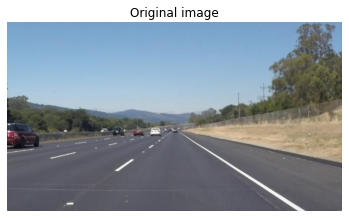

In [5]:
nx = 9
ny = 6
folder_calibration = glob.glob("camera_cal/calibration[1-7].jpg")
#print(folder_calibration)
calib_params = camera_calibration(folder_calibration,nx,ny,showMe=1)
print('RMS Error of Camera calibration:{:.3f}'.format(calib_params['ret']))
print('This number must be between 0.1 and 1.0')
imgs_tests = glob.glob('images/*.jpg')
original_img = np.random.choice(imgs_tests)
original_img = cv2.imread("images/test 3.jpg")
original_img = cv2.cvtColor(original_img,cv2.COLOR_BGR2RGB)
display(original_img, 'Original image', color = 0)

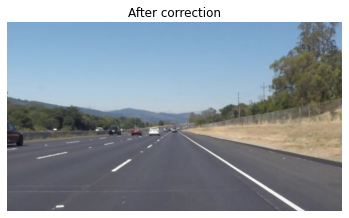

In [6]:
corr_img = correction(original_img,calib_params,showMe=1)
display(corr_img,'After correction',color = 0)

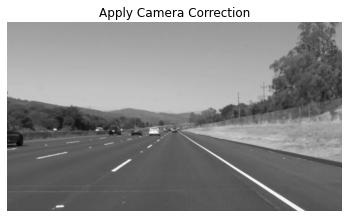

In [7]:
# calib_params is get from white/black chessborad 
gray_ex = cv2.cvtColor(corr_img,cv2.COLOR_RGB2GRAY)
display(gray_ex,'Apply Camera Correction',color = 0)

# Threshold Binary
After we get gray image, we need calculate gradient along X axis 

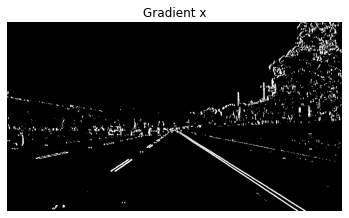

In [8]:
def directional_gradient(img,direction = 'x',thresh=[0,255]):
    '''
    use Sobel operator to calcuate gradient in x direction 
    img: Gray image
    direction: x or y axis 
    thresh: apply threshold on pixel intensity of gradient image
    output is binary image
    '''
    if direction == 'x':
        sobel = cv2.Sobel(img,cv2.CV_64F,1,0)
    elif direction == 'y':
        sobel = cv2.Sobel(img,cv2.CV_64F,0,1)
    sobel_abs = np.absolute(sobel) 
    scaled_sobel = np.uint8(sobel_abs*255/np.max(sobel_abs))
    binary_output = np.zeros_like(sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output
gradx_thresh = [25,255]
gradx = directional_gradient(gray_ex,direction='x',thresh = gradx_thresh)
display(gradx,'Gradient x', color = 0)

## Color Transform
Change undistorted image to HLS, keep S channel 

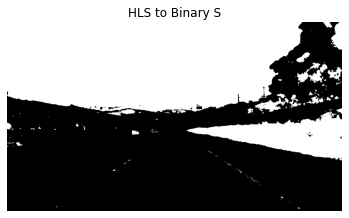

In [9]:
def color_binary(img,dst_format='HLS',ch = 2,ch_thresh=[0,255]):
    '''
    Color thresholding on channel S
    img: RGB
    dst_format: destination format(HLS OR HSV)
    ch_thresh: pixel intensity threshold on channel S
    output is binary image
    '''
    if dst_format =='HSV':
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        ch_binary = np.zeros_like(img[:,:,int(ch-1)])
        ch_binary[(img[:,:,int(ch-1)]>=ch_thresh[0])&(img[:,:,int(ch-1)]<=ch_thresh[1])] = 1
    else:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        ch_binary = np.zeros_like(img[:,:,int(ch-1)])
        ch_binary[(img[:,:,int(ch-1)]>=ch_thresh[0])&(img[:,:,int(ch-1)]<=ch_thresh[1])] = 1
    return ch_binary
ch_thresh = [50,255]
ch3_hls_binary = color_binary(corr_img,dst_format='HLS',ch=3,ch_thresh=ch_thresh)
display(ch3_hls_binary,'HLS to Binary S',color=0)


### Combine Gradx and Binary S

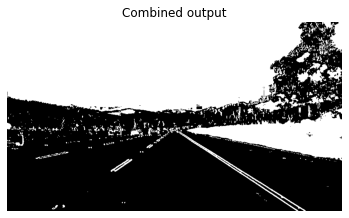

In [10]:
combined_output = np.zeros_like(gradx)
combined_output[(gradx == 1)|(ch3_hls_binary==1)] = 1
display(combined_output,'Combined output',color=0)

### Use ROI mask to remove noise and background

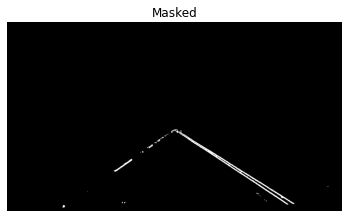

In [11]:
mask = np.zeros_like(combined_output)
vertices = np.array([[(50,600),(480,305),(800,400),(1000,500)]],dtype = np.int32)
cv2.fillPoly(mask,vertices,1)
masked_image = cv2.bitwise_and(combined_output,mask)
display(masked_image,'Masked',color=0)


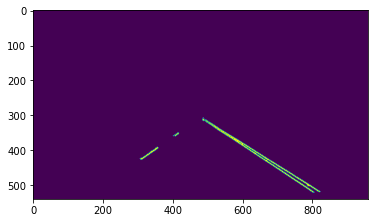

In [12]:
min_sz = 50
cleaned = morphology.remove_small_objects(masked_image.astype('bool'),min_size=min_sz,connectivity=2)
#display(cleaned,'cleaned',color=0)
plt.imshow(cleaned)

## Perspective Transform
We use birds_eye() function to view the undistorted image in a birds eye view

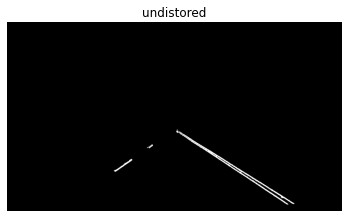

In [213]:
def birdView(img,M):
    '''
    Transform image to birdeye view
    img: binary image
    M: Transformation matrix
    return a wraped image
    '''
    # Grab the image shape
    img_sz = (img.shape[1],img.shape[0])
    img_warped = cv2.warpPerspective(img,M,img_sz,flags = cv2.INTER_LINEAR)
    return img_warped
def perspective_transform(src_pts,dst_pts):
    '''
    perspective transform
    args: source and destination points
    return M and Minv
    '''
    M = cv2.getPerspectiveTransform(src_pts,dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts,src_pts)
    return {'M':M, 'Minv':Minv}
# Orginal image to bird view (transformation)
# Source points - defined area of lane line edges
src_pts = np.float32([[200,520],[340,400],[500,400],[800,520]])
# 4 destination points to transfer
dst_pts = np.float32([[200,520],[150,0],[520,0],[800,520]])

transform_matrix = perspective_transform(src_pts, dst_pts)
warped_image = birdView(cleaned*1.0, transform_matrix['M'])
display(cleaned, 'undistored',color=0)  

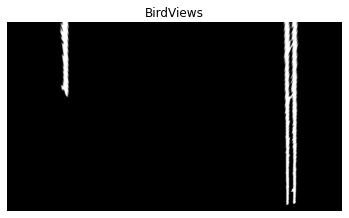

In [214]:
display(warped_image,'BirdViews',color = 0)

## Lane pixels detection use Histogram
A method based on pixels histogram

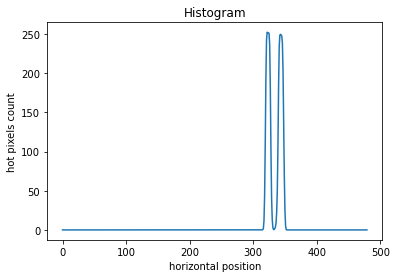

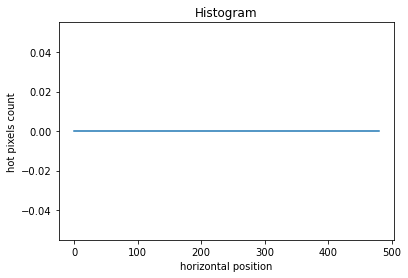

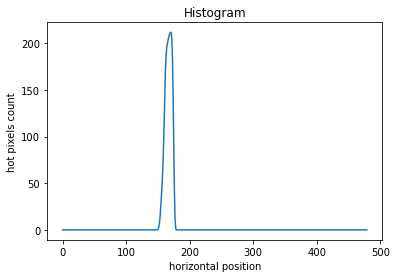

In [220]:
def find_centriod(image,peak_thresh,window,showMe):
    '''
    find centriod in a window using histogram of hotpixels
    image: binary image
    window with specs {'x0','y0','width','height'}
    (x0,y0) is coordinates of bottom-left corner of window
    return x-position of centriod, peak intensity and hotpixels_cnt in window
    '''
    
    # crop image to window dimension
    mask_window = image[round(window['y0'] - window['height']):round(window['y0']),
                       round(window['x0']):round(window['x0'] + window['width'])]
    histogram = np.sum(mask_window,axis = 0)
    centroid = np.argmax(histogram)
    hotpixels_cnt = np.sum(histogram)
    peak_intensity = histogram[centroid]
    if peak_intensity <= peak_thresh:
        centroid = int(round(window['x0'] + window['width']/2))
        peak_intensity = 0
    else: 
        centroid = int(round(centroid+window['x0']))
    if showMe:
        plt.plot(histogram)
        plt.title('Histogram')
        plt.xlabel('horizontal position')
        plt.ylabel('hot pixels count')
        plt.show()
    return (centroid, peak_intensity, hotpixels_cnt)
def find_starter_centroids(image,x0,peak_thresh,showMe):
    '''
    find starter centroids using histogram
    peak_thresh: if peak intensity is below a threshold use histogram on the full height of the image
    rethurn x-position of centroid and peak intensity
    '''
    window = {'x0':x0,'y0':image.shape[0],'width':image.shape[1]/2,'height':image.shape[0]/2}  
    # get centroid
    centroid , peak_intensity,_ = find_centriod(image,peak_thresh,window,showMe)
    if peak_intensity<peak_thresh:
        window['height'] = image.shape[0]
        centroid,peak_intensity,_ = find_centriod(image,peak_thresh,window,showMe)
    return {'centroid':centroid,'intensity':peak_intensity}
    # if number of histogram pixels in window is below 0, consider then as noise and does not attempt 
    # to get centriod
peak_thresh = 10
showMe = 1
centroid_starter_right = find_starter_centroids(warped_image,x0=warped_image.shape[1]/2,
                                                   peak_thresh=peak_thresh,showMe=showMe)
centroid_starter_left = find_starter_centroids(warped_image,x0=0,peak_thresh=peak_thresh,
                                                  showMe=showMe)    

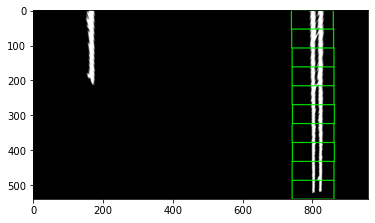

In [237]:
def run_sliding_window(image,centroid_starter,sliding_window_specs,showMe = showMe):
    '''
    Run sliding window from bottom to top of the image and return indexes of the hotpixels associated with lane
    image:binary image
    centroid_starter:centroid starting location sliding window
    sliding_window_specs:['width','n_steps']
        width of sliding window
        number of steps of sliding window alog vertical axis
    return {'x':[],'y':[]}
        coordiantes of all hotpixels detected by sliding window
        coordinates of alll centroids recorded but not used yet!        
    '''
    #Initialize sliding window
    window = {'x0':centroid_starter-int(sliding_window_specs['width']/2),
              'y0':image.shape[0],'width':sliding_window_specs['width'],
              'height':round(image.shape[0]/sliding_window_specs['n_steps'])}
    hotpixels_log = {'x':[],'y':[]}
    centroids_log = []
    if showMe:
        out_img = (np.dstack((image,image,image))*255).astype('uint8')
    for step in range(sliding_window_specs['n_steps']):
        if window['x0']<0: window['x0'] = 0
        if (window['x0']+sliding_window_specs['width'])>image.shape[1]:
            window['x0'] = image.shape[1] - sliding_window_specs['width']
        centroid,peak_intensity,hotpixels_cnt = find_centriod(image,peak_thresh,window,showMe=0)
        if step==0:
            starter_centroid = centroid
        if hotpixels_cnt/(window['width']*window['height'])>0.6:
            window['width'] = window['width']*2
            window['x0']  = round(window['x0']-window['width']/2)
            if (window['x0']<0):window['x0']=0
            if (window['x0']+window['width'])>image.shape[1]:
                window['x0'] = image.shape[1]-window['width']
            centroid,peak_intensity,hotpixels_cnt = find_centroid(image,peak_thresh,window,showMe=0)          
            
        #if showMe:
            #print('peak intensity{}'.format(peak_intensity))
            #print('This is centroid:{}'.format(centroid))
        mask_window = np.zeros_like(image)
        mask_window[window['y0']-window['height']:window['y0'],
                    window['x0']:window['x0']+window['width']]\
            = image[window['y0']-window['height']:window['y0'],
                window['x0']:window['x0']+window['width']]
        
        hotpixels = np.nonzero(mask_window)
        #print(hotpixels_log['x'])
        
        hotpixels_log['x'].extend(hotpixels[0].tolist())
        hotpixels_log['y'].extend(hotpixels[1].tolist())
        # update record of centroid
        centroids_log.append(centroid)
        
        if showMe:
            cv2.rectangle(out_img,
                            (window['x0'],window['y0']-window['height']),
                            (window['x0']+window['width'],window['y0']),(0,255,0),2)
            
            if int(window['y0'])==68:
                plt.imshow(out_img)
                plt.show()
        
            #print(window['y0'])
            plt.imshow(out_img)
        
        # set next position of window and use standard sliding window width
        window['width'] = sliding_window_specs['width']
        window['x0'] = round(centroid-window['width']/2)
        window['y0'] = window['y0'] - window['height']
    return hotpixels_log
sliding_window_specs = {'width':120,'n_steps':10}
log_lineLeft = run_sliding_window(warped_image,centroid_starter_left['centroid'],sliding_window_specs,showMe=showMe)
log_lineRight = run_sliding_window(warped_image,centroid_starter_right['centroid'],sliding_window_specs,showMe=showMe)

In [224]:
def MahalanobisDist(x,y):
    '''
    Mahalanobis Distance for bi-variate distribution
    
    '''
    covariance_xy = np.cov(x,y,rowvar=0)
    inv_covariance_xy = np.linalg.inv(covariance_xy)
    xy_mean = np.mean(x),np.mean(y)
    x_diff = np.array([x_i-xy_mean[0] for x_i in x])
    y_diff = np.array([y_i-xy_mean[1] for y_i in y])
    diff_xy = np.transpose([x_diff,y_diff])
    
    md = []
    for i in range(len(diff_xy)):
        md.append(np.sqrt(np.dot(np.dot(np.transpose(diff_xy[i]),inv_covariance_xy),diff_xy[i])))
    return md
    
def MD_removeOutliers(x,y,MD_thresh):
    '''
    remove pixels outliers using Mahalonobis distance
    '''
    MD = MahalanobisDist(x,y)
    threshold = np.mean(MD)*MD_thresh
    nx,ny,outliers = [],[],[]
    for i in range(len(MD)):
        if MD[i]<=threshold:
            nx.append(x[i])
            ny.append(y[i])
        else:
            outliers.append(i)
    return (nx,ny)
MD_thresh = 1.8
log_lineLeft['x'],log_lineLeft['y'] = \
MD_removeOutliers(log_lineLeft['x'],log_lineLeft['y'],MD_thresh)
log_lineRight['x'],log_lineRight['y'] = \
MD_removeOutliers(log_lineRight['x'],log_lineRight['y'],MD_thresh)

In [225]:
def update_tracker(tracker,new_value):
    '''
    update tracker(self.bestfit or self.bestfit_real or radO Curv or hotpixels) with new coeffs
    new_coeffs is of the form {'a2':[val2,...],'a1':[va'1,...],'a0':[val0,...]}
    tracker is of the form {'a2':[val2,...]}
    update tracker of radius of curvature
    update allx and ally with hotpixels coordinates from last sliding window
    '''
    if tracker =='bestfit':
        bestfit['a0'].append(new_value['a0'])
        bestfit['a1'].append(new_value['a1'])
        bestfit['a2'].append(new_value['a2'])
    elif tracker == 'bestfit_real':
        bestfit_real['a0'].append(new_value['a0'])
        bestfit_real['a1'].append(new_value['a1'])
        bestfit_real['a2'].append(new_value['a2'])
    elif tracker == 'radOfCurvature':
        radOfCurv_tracker.append(new_value)
    elif tracker == 'hotpixels':
        allx.append(new_value['x'])
        ally.append(new_value['y'])
buffer_sz = 5
allx = deque([],maxlen=buffer_sz)
ally = deque([],maxlen=buffer_sz)        
bestfit = {'a0':deque([],maxlen=buffer_sz),
                       'a1':deque([],maxlen = buffer_sz),
                       'a2':deque([],maxlen=buffer_sz)}
bestfit_real = {'a0':deque([],maxlen=buffer_sz),
                            'a1':deque([],maxlen=buffer_sz),
                            'a2':deque([],maxlen=buffer_sz)}
radOfCurv_tracker = deque([],maxlen=buffer_sz)


update_tracker('hotpixels',log_lineRight)
update_tracker('hotpixels',log_lineLeft)
multiframe_r = {'x':[val for sublist in allx for val in sublist],
                   'y':[val for sublist in ally for val in sublist]}
multiframe_l = {'x':[val for sublist in allx for val in sublist],
                   'y':[val for sublist in ally for val in sublist]}
#fit to polynomial in pixel space
def polynomial_fit(data):
    '''
    多项式拟合
    a0+a1 x+a2 x**2
    data:dictionary with x and y values{'x':[],'y':[]}
    '''
    a2,a1,a0 = np.polyfit(data['x'],data['y'],2)
    return {'a0':a0,'a1':a1,'a2':a2}
#merters per pixel in y or x dimension
ym_per_pix = 12/450
xm_per_pix = 3.7/911
fit_lineLeft = polynomial_fit(multiframe_l)
fit_lineLeft_real = polynomial_fit({'x':[i*ym_per_pix for i in multiframe_l['x']],
                                    'y':[i*xm_per_pix for i in multiframe_l['y']]})
fit_lineRight = polynomial_fit(multiframe_r)
fit_lineRight_real = polynomial_fit({'x':[i*ym_per_pix for i in multiframe_r['x']],
                                               'y':[i*xm_per_pix for i in multiframe_r['y']]})

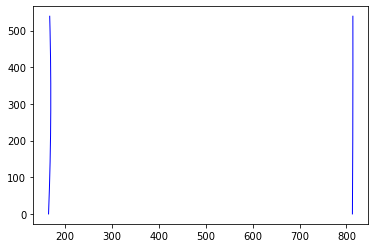

In [226]:
def predict_line(x0,xmax,coeffs):
    '''
    predict road line using polyfit cofficient
    x vaues are in range (x0,xmax)
    polyfit coeffs:{'a2':,'a1':,'a2':}
    returns array of [x,y] predicted points ,x along image vertical / y along image horizontal direction
    '''
    x_pts = np.linspace(x0,xmax-1,num=xmax)
    pred = coeffs['a2']*x_pts**2+coeffs['a1']*x_pts+coeffs['a0']
    return np.column_stack((x_pts,pred))
fit_lineRight_singleframe = polynomial_fit(log_lineRight)
fit_lineLeft_singleframe = polynomial_fit(log_lineLeft)
var_pts = np.linspace(0,corr_img.shape[0]-1,num=corr_img.shape[0])
pred_lineLeft_singleframe = predict_line(0,corr_img.shape[0],fit_lineLeft_singleframe)
pred_lineRight_sigleframe = predict_line(0,corr_img.shape[0],fit_lineRight_singleframe)
plt.plot(pred_lineLeft_singleframe[:,1],pred_lineLeft_singleframe[:,0],'b-',label='singleframe',linewidth=1)
plt.plot(pred_lineRight_sigleframe[:,1],pred_lineRight_sigleframe[:,0],'b-',label='singleframe',linewidth=1)

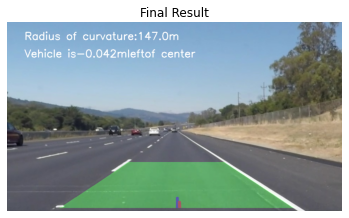

In [227]:
def compute_radOfCurvature(coeffs,pt):
    return ((1+(2*coeffs['a2']*pt+coeffs['a1'])**2)**1.5)/np.absolute(2*coeffs['a2'])
pt_curvature = corr_img.shape[0]
radOfCurv_r = compute_radOfCurvature(fit_lineRight_real,pt_curvature*ym_per_pix)
radOfCurv_l = compute_radOfCurvature(fit_lineLeft_real,pt_curvature*ym_per_pix)
average_radCurv = (radOfCurv_r+radOfCurv_l)/2

center_of_lane = (pred_lineLeft_singleframe[:,1][-1]+pred_lineRight_sigleframe[:,1][-1])/2
offset = (corr_img.shape[1]/2 - center_of_lane)*xm_per_pix

side_pos = 'right'
if offset <0:
    side_pos = 'left'
wrap_zero = np.zeros_like(gray_ex).astype(np.uint8)
color_wrap = np.dstack((wrap_zero,wrap_zero,wrap_zero))
left_fitx = fit_lineLeft_singleframe['a2']*var_pts**2 + fit_lineLeft_singleframe['a1']*var_pts + fit_lineLeft_singleframe['a0']
right_fitx = fit_lineRight_singleframe['a2']*var_pts**2 + fit_lineRight_singleframe['a1']*var_pts+fit_lineRight_singleframe['a0']
pts_left = np.array([np.transpose(np.vstack([left_fitx,var_pts]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,var_pts])))])    
pts = np.hstack((pts_left,pts_right))
cv2.fillPoly(color_wrap,np.int_([pts]),(0,255,0))
cv2.putText(color_wrap,'|',(int(corr_img.shape[1]/2),corr_img.shape[0]-10),cv2.FONT_HERSHEY_SIMPLEX,2,(0,0,255),8)
cv2.putText(color_wrap,'|',(int(center_of_lane),corr_img.shape[0]-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),8)  
newwrap = cv2.warpPerspective(color_wrap,transform_matrix['Minv'],(corr_img.shape[1],corr_img.shape[0]))
result = cv2.addWeighted(corr_img,1,newwrap,0.3,0) 
cv2.putText(result,'Vehicle is' + str(round(offset,3))+'m'+side_pos+'of center',
            (50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness=2)
cv2.putText(result,'Radius of curvature:'+str(round(average_radCurv))+'m',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness=2) 
if showMe:
    plt.title('Final Result')
    plt.imshow(result)
    plt.axis('off')
    plt.show()